In [1]:
import matplotlib.pyplot as plt
import models
import numpy as np
from functions import spectrum, batch

In [2]:
import importlib
models = importlib.reload(models)
spectrum = importlib.reload(spectrum)
batch = importlib.reload(batch)

In [3]:
# create a sequential model
model = models.build_1d_cnn_model(256)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 256, 1)           4         
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 225, 64)           2112      
                                                                 
 conv1d_1 (Conv1D)           (None, 218, 16)           8208      
                                                                 
 conv1d_2 (Conv1D)           (None, 217, 4)            132       
                                                                 
 dense (Dense)               (None, 217, 3)            15        
                                                        

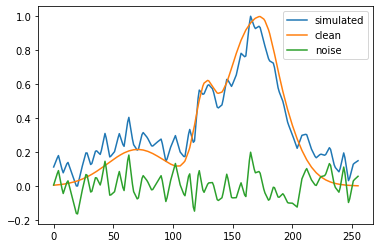

In [5]:
# Generate random noisy data
random_data = spectrum.generate_spectrum("gaussian", 256, np.random.randint(0, 10))
plt.plot(random_data.simulated, label="simulated")
plt.plot(random_data.clean, label="clean")
plt.plot(random_data.noise, label="noise")
plt.legend()
plt.show()

In [8]:
def func():
    spect = spectrum.generate_spectrum("gaussian", 256, np.random.randint(0, 10))
    return spect.simulated, spect.clean

X, y = batch.generate_batch(func)

C:\Users\jerem\Code\tf_model\functions\functions.py:24: RuntimeWarning: invalid value encountered in true_divide
  return result / np.max(result)


In [ ]:
history = model.fit(X, y, epochs=5, verbose=1,
                    validation_split=0.25, batch_size=512)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Epoch 1/5
